# Capital Asset Pricing Model and Linear Regression Model Analysis

This section I discuss regression analysis and how it plays significant role in finance, asset pricing, and capital market. In statistical modeling, regression analysis is a set of statistical processess for estimating relationships between variables. It is an important techniques of which many other algorithms can be developed and based on.

Regression models (both linear and non-linear) are used to predict real values, such as stock returns. This python notebook we are going to build a vanilla regression model using one benchmark and one target fund. I will cover
- Environment Initiation
- Data Generation
- Visualization
- CAPM and Regression Analysis
- Software Development / Product Management

## Environment Initiation

Let us initiate coding environment by setting up libraries

In [1]:
from scipy import stats
import pandas as pd
import numpy as np
import yfinance as yf

Let us start by setting up parameters and download data.

In [2]:
# Define function
def getDatafromYF(ticker, start_date, end_date):
    stockData = yf.download(ticker, start_date, end_date)
    return stockData
# End function

## Data Generation

Now let us apply helper function defined above and parameters desired to download live data.

In [3]:
start_date = pd.to_datetime('2013-01-01')
end_date = pd.to_datetime('2019-12-6')
tickers = ['AAPL', 'SPY']

# Start with Dictionary (this is where data is saved)
stockData = {}
for i in tickers:
    stockData[i] = pd.DataFrame(getDatafromYF(str(i), start_date, end_date))
    close = stockData[i]['Adj Close']
    stockData[i]['Normalize Return'] = close / close.shift() - 1

# Take a look
print(stockData[tickers[0]].head(3)) # this is desired stock
print(stockData[tickers[1]].head(3)) # this is benchmark (in this case, it is S&P 500 SPDR Index Fund: SPY)

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
                 Open       High        Low      Close  Adj Close     Volume  \
Date                                                                           
2013-01-02  79.117142  79.285713  77.375717  78.432854  68.850548  140129500   
2013-01-03  78.268570  78.524284  77.285713  77.442856  67.981491   88241300   
2013-01-04  76.709999  76.947144  75.118568  75.285713  66.087891  148583400   

            Normalize Return  
Date                          
2013-01-02               NaN  
2013-01-03         -0.012622  
2013-01-04         -0.027855  
                  Open        High         Low       Close   Adj Close  \
Date                                                                     
2013-01-02  145.110001  146.149994  144.729996  146.059998  127.877869   
2013-01-03  145.990005  146.369995  145.339996  145.729996  127.588974   
2013-01-04

## Visualization

This section let us visualize what the performance of the listed stocks look like comparing with benchmark.

In [4]:
import matplotlib.pyplot as plt

Text(0.5,1,'Cumulative Return')

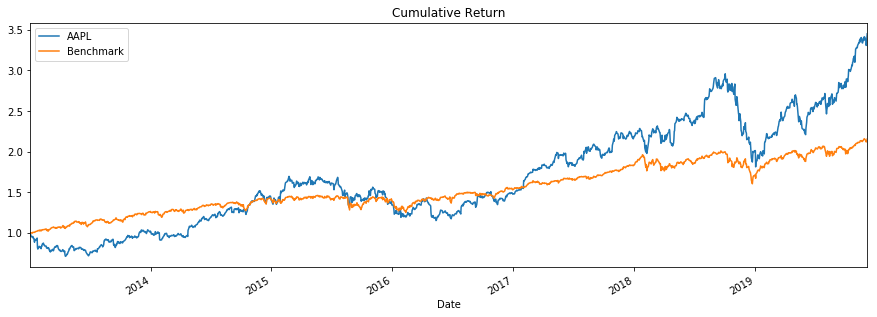

In [5]:
target = stockData[tickers[0]]
benchmark = stockData[tickers[1]]
target['Cumulative'] = target['Close'] / target['Close'].iloc[0]
benchmark['Cumulative'] = benchmark['Close'] / benchmark['Close'].iloc[0]
target['Cumulative'].plot(label=tickers[0], figsize = (15,5))
benchmark['Cumulative'].plot(label='Benchmark')
plt.legend()
plt.title('Cumulative Return')

The above plot shows us the historical data converted and rescaled so that both prices start with the same amount, ex. $\$1$. In other words, consider a unit of investment ($\$10$k, $\$100$k, $\$1$ million, ...) this plot tells us what each candidate looks like over the course of the same historical period.

Next we want to see, in terms of percentages, what are the returns look like for these two candidates.

Text(0.5,1,'Daily Returns for Target and Benchmark')

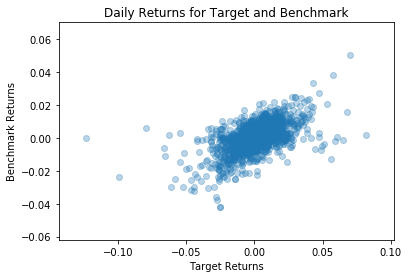

In [6]:
target['Daily Return'] = target['Close'].pct_change(1)
benchmark['Daily Return'] = benchmark['Close'].pct_change(1)
plt.scatter(target['Daily Return'], benchmark['Daily Return'], alpha = 0.3)
plt.xlabel('Target Returns')
plt.ylabel('Benchmark Returns')
plt.title('Daily Returns for Target and Benchmark')

We can also look at monthly returns by changing the input of *.pct_change()* function.

Text(0.5,1,'Daily Returns for Target and Benchmark')

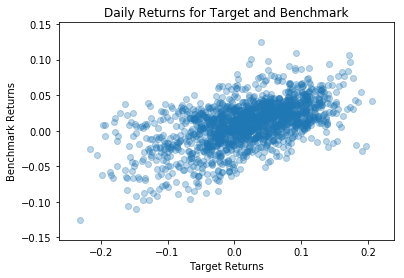

In [7]:
target['Daily Return'] = target['Close'].pct_change(20)
benchmark['Daily Return'] = benchmark['Close'].pct_change(20)
plt.scatter(target['Daily Return'], benchmark['Daily Return'], alpha = 0.3)
plt.xlabel('Target Returns')
plt.ylabel('Benchmark Returns')
plt.title('Daily Returns for Target and Benchmark')

We can see the output of the graphs above follow multivariate normal distribution. In mathematical form, we have data that is two stocks and about 6 years of length. We can write this data in matrix form and we have
$$\textbf{X} \sim \mathcal{N}([\mu_1, \mu_2]^T, \Sigma)$$
while $\mathcal{N}$ represents multivariate normal distribution, $\mu_1$ and $\mu_2$ are expectations for the first and the second random variable, respectively, and $\Sigma$ is the covariance matrix.

## CAPM and Regression Analysis

As discussed above, we already have normality assumption listed out which is one of the most important assumption in linear regression analysis and multivariate regression model analysis.

In this case, we are dealing with a very simple regression model
$$y = \beta x + \alpha + \epsilon$$
and notice that 
- $y$ is the target fund (here it is Apple) ,
- $x$ is the benchmark (here it is S&P 500 SPDR Index Fund: SPY),
- $\alpha$ is the intercept or the constant term, this is the metric of how much the target fund beat/lose to the benchmark,
- $\epsilon$ is the noise that cannot be quantified and $\epsilon \sim \mathcal{N}(0,1)$.

This singular-factor model is an application derived from Capital Asset Pricing Model.

In [8]:
from sklearn.linear_model import LinearRegression
lm = LinearRegression()
x = np.array(benchmark['Daily Return']).reshape(-1, 1)
x = np.array(x[~np.isnan(x)]).reshape(-1, 1)
y = np.array(target['Daily Return']).reshape(-1, 1)
y = np.array(y[~np.isnan(y)]).reshape(-1, 1)
linearModel = lm.fit(x, y)
print(linearModel.coef_)
print(linearModel.intercept_)

[[1.24834246]]
[0.00636968]


From above results, we know that the coefficient is 1.25 and the intercept is 0.006. This slope means how much the target changes when benchmark changes by a unit. In other words, the target will incrase 1.24% if the market benchmark increases 1% and this statement holds true on average. The intercept means that on average the target fund outperforms benchmark by 0.006. 

Next, let us use the linear regression model we just learned to come up with some predictions. Notice that here we are heading into machine learning.

In [9]:
y_pred = linearModel.predict(x)
print('Returns:', y)
print('Estimated Returns:', y_pred)

Returns: [[-0.17037317]
 [-0.16321711]
 [-0.16068309]
 ...
 [ 0.01792862]
 [ 0.03242107]
 [ 0.04347993]]
Estimated Returns: [[0.03747995]
 [0.05356916]
 [0.03340557]
 ...
 [0.02438143]
 [0.02636911]
 [0.03346883]]


We have the original returns for target. We just did a vanilla regression analysis and use *.predict()* function to estimate the predicted returns. How well is this linear regression model doing?

We can use *.metrics* from *sklearn* to check out $R^2$ and also root mean square error (RMSE).

In [10]:
from sklearn.metrics import r2_score
score = r2_score(y, y_pred)
print('R-square is:', score)
RMSE = np.sqrt(np.mean((y - y_pred)**2))
print('Root Mean Square Error (RMSE):', RMSE)

R-square is: 0.30324481152101035
Root Mean Square Error (RMSE): 0.05887940899354586


We have $R^2$ to be 0.30 which means that our model is able to explain 30\% of the variance of the dependent variable. We also have RMSE to be about 5.8\% which means that on average the model predicts dependent variable with error range +/- 5.8\%.

A quick remark, what does RMSE of 5.8\% look like?

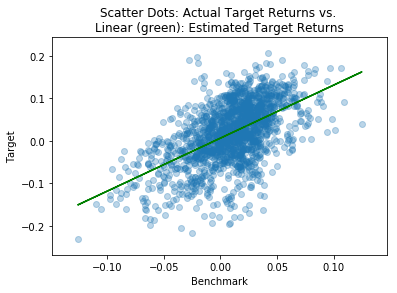

In [11]:
plt.scatter(x, y, alpha=0.3)
plt.plot(x, y_pred, 'g')
plt.xlabel('Benchmark')
plt.ylabel('Target')
plt.title('Scatter Dots: Actual Target Returns vs. \nLinear (green): Estimated Target Returns')
plt.show()

## Software Development / Product Management

The final section I always land on software developmentand product management. This means we want to soft code a package (essentially a function) that allow us to pack everything together in a neat and efficient manner for future usage.

In [12]:
# Define function
def mmCAPM(tickers, start_date, end_date):
    from scipy import stats
    import pandas as pd
    import numpy as np
    import yfinance as yf

    # Define function
    def getDatafromYF(ticker, start_date, end_date):
        stockData = yf.download(ticker, start_date, end_date)
        return stockData
    # End function

    # Start with Dictionary (this is where data is saved)
    stockData = {}
    for i in tickers:
        stockData[i] = pd.DataFrame(getDatafromYF(str(i), start_date, end_date))
        close = stockData[i]['Adj Close']
        stockData[i]['Normalize Return'] = close / close.shift() - 1

    import matplotlib.pyplot as plt
    target = stockData[tickers[0]]
    benchmark = stockData[tickers[1]]
    target['Cumulative'] = target['Close'] / target['Close'].iloc[0]
    benchmark['Cumulative'] = benchmark['Close'] / benchmark['Close'].iloc[0]
    target['Cumulative'].plot(label=tickers[0], figsize = (15,5))
    benchmark['Cumulative'].plot(label='Benchmark')
    plt.legend()
    plt.title('Cumulative Return')
    plt.show()

    target['Daily Return'] = target['Close'].pct_change(20)
    benchmark['Daily Return'] = benchmark['Close'].pct_change(20)
    plt.scatter(target['Daily Return'], benchmark['Daily Return'], alpha = 0.3)
    plt.xlabel('Target Returns')
    plt.ylabel('Benchmark Returns')
    plt.title('Daily Returns for Target and Benchmark')
    plt.show()

    from sklearn.linear_model import LinearRegression
    lm = LinearRegression()
    x = np.array(benchmark['Daily Return']).reshape(-1, 1)
    x = np.array(x[~np.isnan(x)]).reshape(-1, 1)
    y = np.array(target['Daily Return']).reshape(-1, 1)
    y = np.array(y[~np.isnan(y)]).reshape(-1, 1)
    linearModel = lm.fit(x, y)
    y_pred = linearModel.predict(x)

    plt.scatter(x, y, alpha=0.3)
    plt.plot(x, y_pred, 'g')
    plt.xlabel('Benchmark')
    plt.ylabel('Target')
    plt.title('Scatter Dots: Actual Target Returns vs. \nLinear (green): Estimated Target Returns')
    plt.show()

    from sklearn.metrics import r2_score
    score = r2_score(y, y_pred)
    print('R-square is:', score)
    RMSE = np.sqrt(np.mean((y - y_pred)**2))
    print('Root Mean Square Error (RMSE):', RMSE)

    return {'Beta': linearModel.coef_, 
            'Alpha': linearModel.intercept_, 
            'Returns': y, 
            'Estimated Returns': y_pred, 
            'R square': score, 
            'Root Mean Square Error': RMSE}
# End of function

It's done! Everything is packed together into one function *mmCAPM* which we can store and run for future usage. Let us try it!

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


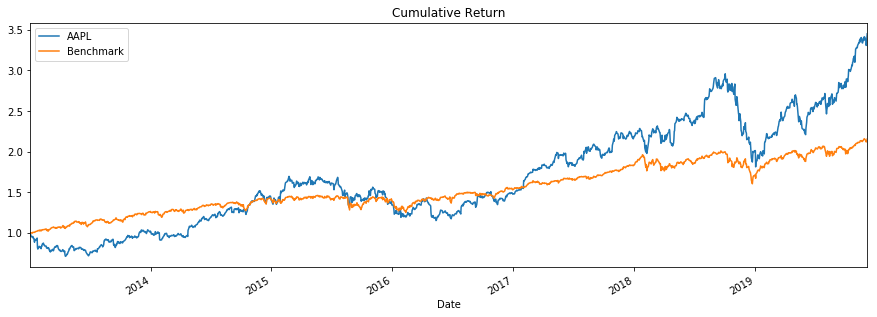

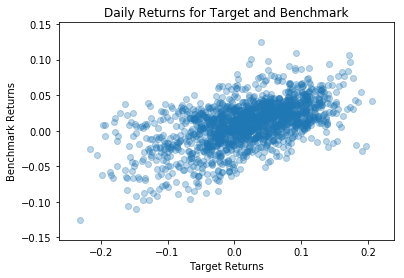

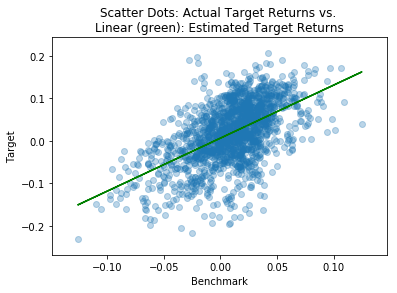

R-square is: 0.30324481152101035
Root Mean Square Error (RMSE): 0.05887940899354586


In [13]:
# Try
start_date = pd.to_datetime('2013-01-01')
end_date = pd.to_datetime('2019-12-6')
tickers = ['AAPL', 'SPY']
testresult = mmCAPM(tickers, start_date, end_date)

In [14]:
print(testresult['Beta'], testresult['Alpha'])

[[1.24834246]] [0.00636968]


## Supplement

This section prints code line by line to investigate the component and building blocks of syntaxes used above.

In [15]:
print(target['Close'])
print(target['Close'].iloc[0])

Date
2013-01-02     78.432854
2013-01-03     77.442856
2013-01-04     75.285713
2013-01-07     74.842857
2013-01-08     75.044289
                 ...    
2019-12-02    264.160004
2019-12-03    259.450012
2019-12-04    261.739990
2019-12-05    265.579987
2019-12-06    270.709991
Name: Close, Length: 1746, dtype: float64
78.43285369873047


In [16]:
x = np.array(benchmark['Daily Return']).reshape(-1, 1)
y = np.array(target['Daily Return']).reshape(-1, 1)
print(x, y)
print(x[~np.isnan(x)])
print(benchmark['Daily Return'])

[[       nan]
 [       nan]
 [       nan]
 ...
 [0.01442853]
 [0.01602078]
 [0.0217081 ]] [[       nan]
 [       nan]
 [       nan]
 ...
 [0.01792862]
 [0.03242107]
 [0.04347993]]
[0.02492126 0.03780972 0.02165743 ... 0.01442853 0.01602078 0.0217081 ]
Date
2013-01-02         NaN
2013-01-03         NaN
2013-01-04         NaN
2013-01-07         NaN
2013-01-08         NaN
                ...   
2019-12-02    0.017966
2019-12-03    0.007092
2019-12-04    0.014429
2019-12-05    0.016021
2019-12-06    0.021708
Name: Daily Return, Length: 1746, dtype: float64
